#  An Introduction to `fenonics`
##### *Generating Dispersion Diagrams with `fenicsx`*

**Josh Tempelman**

University of Illinois at Urbana Champaign



This script is based on the software provided at: https://github.com/jtempelman95/fenonics

Copyright (c) 2023 Joshua R. Tempelman (jrt7@illinois.edu), Connor D. Pierce


### Summary of band computations work flow

The Bloch-band dispersion problem is solved by first defing a geometry, meshing the geometry, defining appropriate boundary conditions, definine an appropriate weak form, and solving the complex-valued eigenvalue problem. These operations are performed as follows:

1. The `gmsh-api` module generates a mesh parameterized by an internal void geometry
4. `dolfinx-mpc`applies the necessary periodc BCs and returns the mass and stiffness matrices
2. `dolfinx` builds a function space on the mesh based on a Bloch-ansatz weak form
5. `scipy` solves the complex eigenproblem at a given wavenumber

The `fenonics` module packages all the operations to conviently solve the band structure, post-process solutions, and visualization results. Default settings return the $\Gamma$-$X$-$M$-$\Gamma$ IBZ, with the option for user defined IBZ to computed by passing the high-symmetry points. 

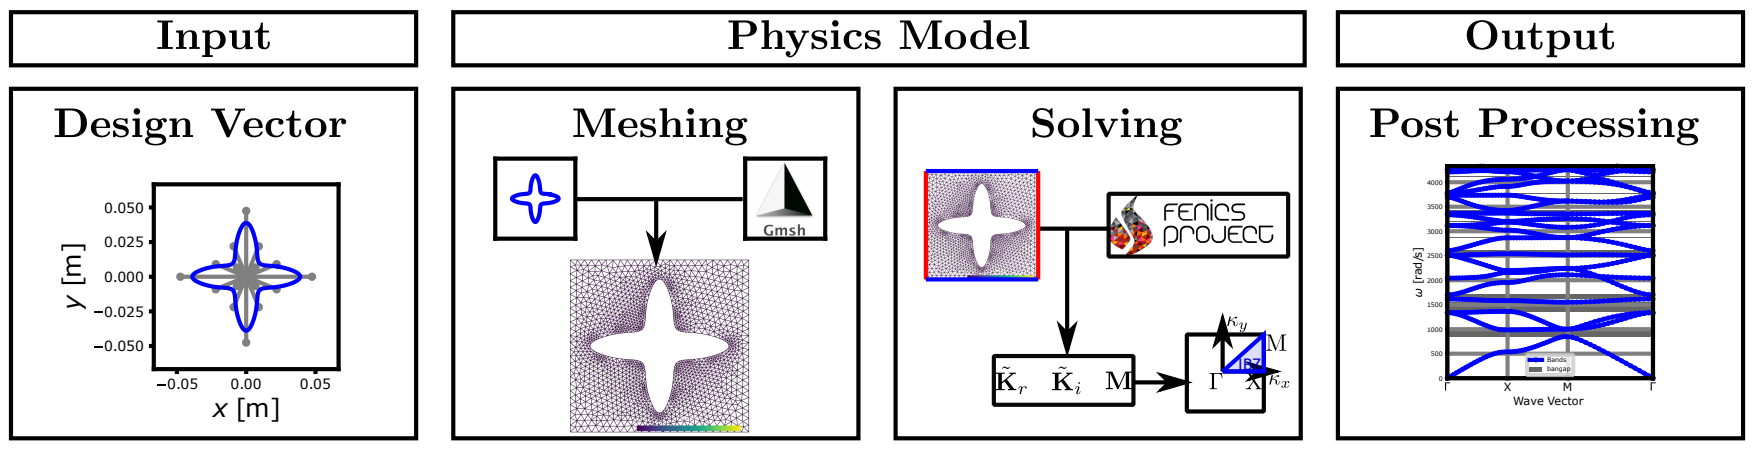

For details on these functions and their implementation, see the `Tutorial_Detailed` noteook, or see the support files within the `fenonics` module


### Notebook Conents:

This script shows how to use the functions from the `fenonics` modules to 

1. Creating the unit cell mesh
2. Visualizing the mesh
3. Generating a dispersion diagram on a default IBZ
4. Generating a disperison diagram on a custom IBZ
5. Post-procssing the disperision computations
6. Visualizng the Bloch-eigenvectors on the mesh

The `fenonics` software is built on the following dependecies:

- `gmsh`
- `Petsc`
- `Scipy`
- `dolfinx`
- `dolfinx-mpc`
- `pyvista`


## Imports

Make sure the fenonics folder is on your path

In [1]:
# Genearal imports                                   
import numpy as np
import matplotlib.pyplot as plt
import pyvista
import dolfinx
from dolfinx.io.gmshio  import model_to_mesh
import gmsh
from mpi4py import MPI

# Fenonics Import                                   
import fenonics as fn

## Part 1: Generating a mesh

We start by defining some parameters for the void in our square unit cell


    a_len   -            Charecterstic unit cell length (primitive basis)
    r        -           vector of points to fit spline to
    Nquads    -          Number of quadrants to repeat spline through (radially)
    offset     -         Offset angle for inclusion geometry
    iscut       -        Choose if inclusion is void or an filled
    da      -           Nominal distance between nodes
    refinement_level -   Choose how much denser mesh gets around refinement field
    refinement_dist  -   Maximum distance of refinement field from refined edges
    isrefined        -   Choose whether or not to refine mesh around internal edges
    meshalg          -   Meshing algorithm for gmsh to use


We convert the gmsh object to a dolfinx mesh. The `model_to_mesh` module returns the mesh in the correct format along with `ct` which account for domain tags constructed in `gmsh`. Thses tags will be needed if assigneing material propeties to multiple domains
 
The quanties are $c$ and $\rho$, for the equation

$$
E\nabla u(x,t) - \rho\frac{\partial^2}{\partial t^2}u(x,t) = 0
$$

If the inclusion gemoetry is not a cut out (`cut = False`), then there are assumed to be two physical domains in the unit cell that need to be defined, so that `c` and `rho` are lists of length 2. Otherwise, they are length 1 for the single domain, 

In [44]:
# Inputs to meshing program
cut         = False
a_len       =   .1
offset      =   0*np.pi
Nquads      =   4
da                  =   a_len/12
meshalg             =   6
refinement_level    =   6
refinement_dist     =   a_len/5
meshalg                 = 6
r  =   np.array([1,.2,.9,.2])*a_len*.95

# Generating the gmsh model
gmsh.model, xpt, ypt = fn.get_mesh(
    a = a_len,  
    r = r,  
    Nquads = Nquads,
    refinement_level= refinement_level,
    da = da,
    refinement_dist = refinement_dist,
    cut = cut,
    symmetry= 'rotated'
)

# Define material properties on the mesh
# Define material properties
if not cut:
    c = [2, 4]  # if solid inclusion (mutlple materail model)
    rho = [20, 50]  # if solid inclusion (mutlple materail model)
else:
    c = [30]  # if void inclusion  (if iscut)
    rho = [1.2]  # if void inclusion  (if iscut)

# Import to dolfinx               
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)



Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.0719318s, CPU 0.07281s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 101 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0499829s, CPU 0.050409s)
Info    : 2488 nodes 5157 elements
to here


## Part 2: Plot the design vector and the produced mesh

The design vector defined by `r`, as well as the path created by the Bspline interpolation can be viewd using the `PlotSpline` function. The corresponding `gmsh` mesh can be visualized usign `pyvista` with the `PlotMesh` function.

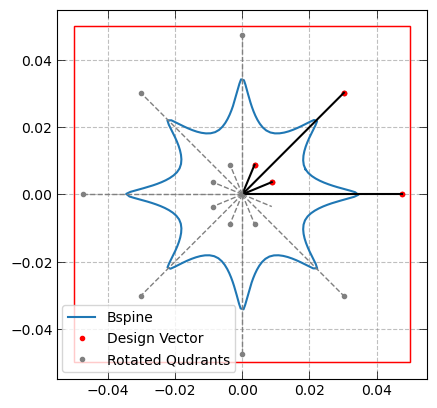

Widget(value="<iframe src='http://localhost:36621/index.html?ui=P_0x7f77c8000820_19&reconnect=auto' style='wid…

In [45]:
plt = fn.PlotSpline(gmsh, r, Nquads, a_len, xpt, ypt)
plt.show()
plotter = fn.plotmesh(mesh,ct)

## Part 3: Solve on the default $\Gamma$-$\rm X$-$\rm M$-$\Gamma$ boundary

The function `solve_bands` computes the dispersion bands over the IBZ. The $\Gamma$-X-M-$\Gamma$ boundary is defined by default. This can be changed to wrap around your own high-symmetry (HS) points (See the next cell to do so). Note that the default IBZ assumes rotationally perioidc symmetry accross quadrants of the unit cell. Breaking this symmetry may require a longer path to formally define the IBZ.


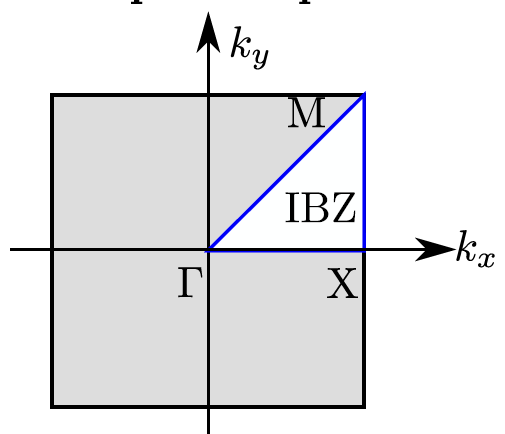



We define the number of $(k_x,k_y)$ pairs to visit with `n_wavevector`, and the number of solutions to return at each wavevector with `n_solutions`.

We also define the function space as `fspace`, which is used when assembling the complex Bloch eigenproblem around the mesh. By default this is `CG` which corresponds to a Lagrange function space. The default order is 1 but can be set to a higher order if desired.

In [52]:
n_wavevector   = 60 # Number of wavevectors to use over the IBZ loop
n_solutions    = 20 # Number of eigensolutions to return at each wavevector
fspace   = 'CG'     # Function space to use on th mesh

# Function to sovle for the disperision on the default IBZ
evals_disp, evec_all, mpc, KX, KY = fn.solve_bands(
    n_wavevector  = n_wavevector, 
    n_solutions = n_solutions, 
    a_len = a_len,
    c = c,  
    rho = rho,  
    fspace = fspace,  
    mesh = mesh, 
    ct = ct
)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing Γ to X
Computing X to M
Computing M to Γ
Time to compute dispersion 4.299
Band computation complete
-----------------
N_dof....4890
N_vectors....20
N_wavenumbers....60
T total....4.299


# Post-Processing and Visualization

We can collect the summary of the band structure with the `getbands()` command. It returns 

    -bgnrm  - frequency normalized band gap widths
    -gapwidths - Non-nomralzied band gap widths
    -gaps - the number of band gaps in the diagram
    -lowbounds  - the lower boundaries of identified band gaps
    -highbound - the upper boundaries of identified band gaps.

To visualize, call the `plotbands()` function from the `PostProcess` module to visual the dispersion curves and band gaps. If `inset=True` then the path traversed in $k$-space will appear in the top-right corner

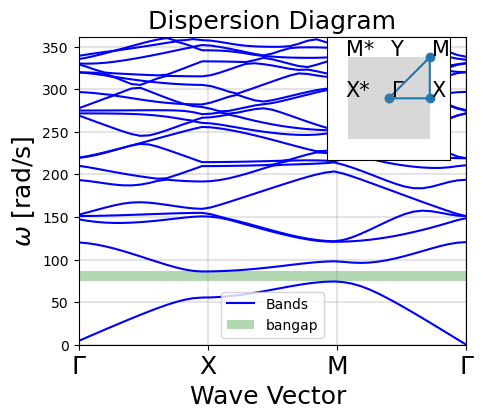

In [53]:
bgnrm, gapwidths, gaps, lowbounds, highbounds = fn.getbands(np.array(evals_disp))
plt = fn.plotbands(bands = np.array(evals_disp), inset = True, 
                KX = KX, KY = KY, a_len= a_len)
plt.show()

# 4. Compute the Dispersion Diagram on custom High-Symmetry points

Here we show how to define your own IBZ path using the `solve_bands_customHS` function.
We solve on the $\Gamma$-$X$-$M$-$Y$-$\Gamma$ boudnary

In [46]:
# Define the high symmetry points of the lattice. We define Gamma (G), X, M, Y, X' (X*), and M' (M*) 
G  = np.array([0,0])                    
X  = np.array([np.pi/a_len, 0])              
M  = np.array([np.pi/a_len, np.pi/a_len])    
Y  = np.array([0, np.pi/a_len] )   
Mp = np.array([-np.pi/a_len, np.pi/a_len])    
Xp = np.array([-np.pi/a_len, 0] )   

# Create a list of high-symmety coordinates to solve over
HSpts = [G, X, M, 
         G, Y, M,
         G, Xp, Mp,
         G, Y, Mp,
         G]

# Define the number of solutions per wavevec and number of wavevecs to solve for
n_solutions  = 30
n_wavevector = len(HSpts)*10

# Solve the eiegensolution. Collect eigenvalues, eigenvectors, constrains, and wavevectors
evals_disp, evec_all, mpc, KX, KY = fn.solve_bands(
    HSpts  = HSpts, 
    n_wavevector  = n_wavevector,  
    n_solutions = n_solutions, a_len = a_len,
    c = c,  
    rho = rho,  
    fspace = 'CG',  
    mesh = mesh, 
    ct = ct
)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing 0.0 to 1.0
Computing 1.0 to 2.0
Computing 2.0 to 3.0
Computing 3.0 to 4.0
Computing 4.0 to 5.0
Computing 5.0 to 6.0
Computing 6.0 to 7.0
Computing 7.0 to 8.0
Computing 8.0 to 9.0
Computing 9.0 to 10.0
Computing 10.0 to 11.0
Computing 11.0 to 12.0
Time to compute dispersion 15.392
Band computation complete
-----------------
N_dof....4890
N_vectors....30
N_wavenumbers....130
T total....15.392


## 5. Plotting the disperison over a custom IBZ


When using the `plotbands` function for a custom IBZ path, you can pass the x-axis labels to the function

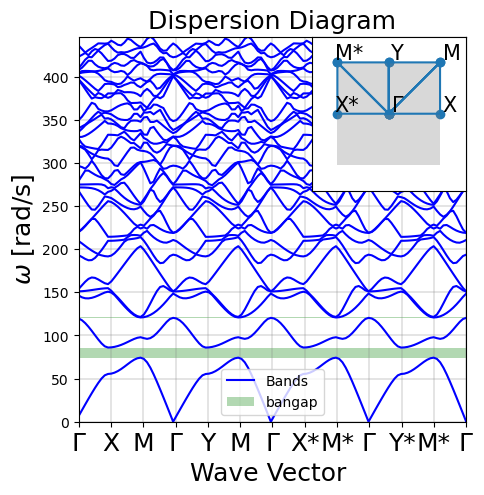

In [47]:
# Define a list of labels for the plotting tool to label the high-symmetry (HS) points
HS_labels = [   
                '$\Gamma$', 'X', 'M', 
                '$\Gamma$', 'Y', 'M',
                '$\Gamma$', 'X*', 'M*',
                '$\Gamma$', 'Y*', 'M*',
                '$\Gamma$'
            ]

# Plotting the dispersion output using the user-defined HS point labels
plt = fn.plotbands(
        bands = np.array(evals_disp), 
        figsize = (5,5), 
        HSpts = HSpts, 
        HS_labels = HS_labels, 
        a_len = a_len, 
        KX = KX, 
        KY = KY, 
        inset = True
)
plt.show()

## 6. Plotting the Bloch-eigenmodes

The `plotvecs` function post-processes the eigensolutions and plots the Bloch eigenmodes on the `gmsh` mesh. You must initialize the `plotter` as a `pyvista.Plotter` object. Also pass in

    -V - the function space of the mesh
    -mpc - the dolfinx-mpc constraint object
    -evecs - the evals solved for by solve_bands
    -eval_number - the index of the eigenvalue to plot
    -wavevec_number - the index of the wav vector to plot

In [51]:
# Initialize the pyvista plotter
plotter = pyvista.Plotter(shape=(1,1) , window_size=(500,500))

# Set the eigenvalue and  wavenumber to plot over
eval_number = 25
wavevec_number = 30
fspace = 'CG'
V = dolfinx.fem.FunctionSpace(mesh,(fspace,1))
plotter = fn.plotvecs(plotter = plotter , V = V, mpc = mpc, 
                            evecs = evec_all, eval_number = eval_number,
                            wavevec_number = wavevec_number,cmap = 'PuOr')
plotter.screenshot()
plotter.show()

Widget(value="<iframe src='http://localhost:36621/index.html?ui=P_0x5f7658794670_23&reconnect=auto' style='wid…